In [1]:
!python3 -m pip install cython
!python3 -m pip install PyMySQL
!python3 -m pip install SQLAlchemy
!python3 -m pip install google-cloud-storage
!python3 -m pip install --upgrade --quiet scikit-sound
!python3 -m pip install --upgrade --quiet pygame
!python3 -m pip install scikit-learn==0.21rc2

!sudo apt-get -y install ffmpeg
!sudo apt-get -y install python3-pymysql

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.2.14-1~deb9u1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-pymysql is already the newest version (0.7.10-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [2]:
import sqlalchemy
import numpy as np

from google.cloud import storage
from numpy.fft import fft, ifft
from sksound.sounds import Sound

from tensorflow.keras.models import load_model

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
%load_ext Cython

In [18]:
# PASSWORDS AND STUFF HERE

In [19]:
settings = {
   'user': db_user,
   'pass': db_password,
   'host': host,
     'db': db_name
}
url = 'mysql+pymysql://{user}:{pass}@{host}/{db}'.format(**settings)  # 5432 is the default port
db = sqlalchemy.create_engine(url)

def run_query(query):
    with db.connect() as conn:
        rows = []
        for row in conn.execute(query).fetchall():
            rows.append(dict(row.items()))
        return rows
    
regions = run_query("""
    SELECT 
        x.encoding, y.year, x.filename, x.start, x.stop
    FROM 
        wdp_ds.not_silent x
    JOIN 
        wdp_ds.encoding y 
    ON x.encoding = y.encoding;
""")

In [30]:
client = storage.Client.from_service_account_json('secret.json')
bucket = client.get_bucket('wdp-data')

In [31]:
regions_by_file = {}
for region in regions:
    k = "audio_files/{}/{}".format(region['year'], region['filename'])
    r = region
    if k not in regions_by_file:
        regions_by_file[k] = []
    regions_by_file[k].append(r)
print(len(regions_by_file))

54


In [14]:
class StreamSpectrogram:
    
    def __init__(self, filename, starts, stops, win=32):
        sound = Sound(filename)      
        self.ranges = [x for x in zip(starts, stops)]
        self.starts = starts
        self.stops = stops
        self.data  = sound.data
        self.fs    = sound.rate
        if len(self.data.shape) > 1:
            self.data = self.data[:, 0]    
        self.win = win

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):        
        if self.i < len(self.ranges): 
            start, stop = self.ranges[self.i]
            raw   = self.data[start:stop]
            spec  = fwd_spectrogram(raw) 
            t,d   = spec.shape
            if t > self.win:
                current = []        
                for i in range(self.win, t + 1, self.win // 2):
                    x      = np.reshape(spec[i - self.win:i], (self.win, d, 1))
                    mu     = np.mean(x)
                    std    = np.std(x) + 1.0
                    window = (x - mu) / std
                    current.append(window)
                self.i += 1
                return np.stack(current)
            else:
                self.i += 1
                return None
        else:
            raise StopIteration
        
def fwd_spectrogram(audio, win=512, step=256):
    '''
    Compute the spectrogram of audio data

    audio: one channel audio
    win: window size for dft sliding window
    step: step size for dft sliding windo
    '''
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        start = win // 2
        dft = np.abs(fft(audio[i - win: i] * hanning))[start:win]
        spectrogram.append(dft)
    return np.array(spectrogram)

In [33]:
encoder = load_model('encoder.h5')
idx     = list(regions_by_file.keys()) 
files   = {}
latent  = [] 
for path in idx:    
    with open("/tmp/audio.m4a", "wb") as file_obj:
        blob = bucket.blob(path)
        blob.download_to_file(file_obj)
    stream = StreamSpectrogram("/tmp/audio.m4a", [r['start'] for r in regions_by_file[path]], [r['stop'] for r in regions_by_file[path]])
    for i, region in enumerate(stream):
        r = regions_by_file[path][i]
        x = region
        if x is not None:
            h = encoder.predict(x)
            latent.append([h, r])

Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to "

In [35]:
import pickle
print(len(latent))
pickle.dump( latent, open( "data.p", "wb" ) )

3272


3272


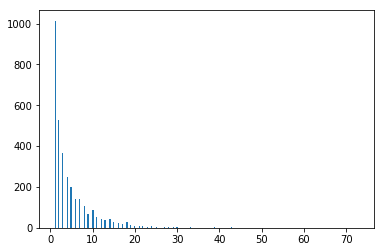

In [4]:
import pickle
import matplotlib.pyplot as plt

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
x = [len(l[0]) for l in latent]
plt.hist(x, bins=250)
plt.show()

In [5]:
%%cython
import pickle
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as np

DTYPE = np.float

cdef double euc(np.ndarray x, np.ndarray y):
    return np.sqrt(np.sum(np.square(x - y)))

cdef double min3(float x, float y, float z):
    cdef float minimum = x
    if y < minimum:
        minimum = y
    if z < minimum:
        minimum = z
    return minimum

cdef double dtw(np.ndarray x, np.ndarray y):
    cdef int n = x.shape[0]
    cdef int m = y.shape[0]
    cdef np.ndarray dp = np.ones((n + 1, m + 1)) * float('inf')
    cdef int i,j
    dp[0,0] = 0.0
    for i in range(1, n + 1):
        for j in range(0, m+1):
            dp[i][j] = euc(x[i - 1, :], y[j - 1, :]) + min3(
                dp[i - 1][j - 1],
                dp[i - 1][j    ],
                dp[i    ][j - 1]
            )
    return dp[n][m]

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
n = len(latent)
distances = np.ones((n, n)) * float('inf')
for i, x in enumerate(latent):
    if i % 10 == 0:
        print("{} / {}".format(i, n))
    for j, y in enumerate(latent):
        if abs(len(x[0]) - len(y[0])) < 10 and i < j:  
            distances[i][j] = dtw(x[0], y[0])
pickle.dump(distances, open( "distances.p", "wb" ) )

610 / 3272
620 / 3272
630 / 3272
640 / 3272
650 / 3272
660 / 3272
670 / 3272
680 / 3272
690 / 3272
700 / 3272
710 / 3272
720 / 3272
730 / 3272
740 / 3272
750 / 3272
760 / 3272
770 / 3272
780 / 3272
790 / 3272
800 / 3272
810 / 3272
820 / 3272
830 / 3272
840 / 3272
850 / 3272
860 / 3272
870 / 3272
880 / 3272
890 / 3272
900 / 3272
910 / 3272
920 / 3272
930 / 3272
940 / 3272
950 / 3272
960 / 3272
970 / 3272
980 / 3272
990 / 3272
1000 / 3272
1010 / 3272
1020 / 3272
1030 / 3272
1040 / 3272
1050 / 3272
1060 / 3272
1070 / 3272
1080 / 3272
1090 / 3272
1100 / 3272
1110 / 3272
1120 / 3272
1130 / 3272
1140 / 3272
1150 / 3272
1160 / 3272
1170 / 3272
1180 / 3272
1190 / 3272
1200 / 3272
1210 / 3272
1220 / 3272
1230 / 3272
1240 / 3272
1250 / 3272
1260 / 3272
1270 / 3272
1280 / 3272
1290 / 3272
1300 / 3272
1310 / 3272
1320 / 3272
1330 / 3272
1340 / 3272
1350 / 3272
1360 / 3272
1370 / 3272
1380 / 3272
1390 / 3272
1400 / 3272
1410 / 3272
1420 / 3272
1430 / 3272
1440 / 3272
1450 / 3272
1460 / 3272
1470 / 

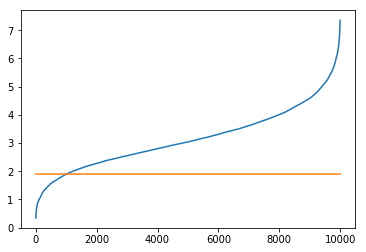

1.8992581129074098


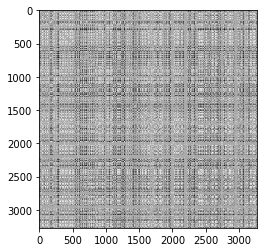

In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

latent    = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances.p", "rb" ) )

for i in range(len(distances)):
    for j in range(len(distances)):
        if not np.isinf(distances[i][j]):
            distances[i][j] /= len(latent[i][0]) + len(latent[j][0])

f = [f for f in distances.flatten() if not np.isinf(f)]
random.shuffle(f)
th = np.percentile(f, 10)

plt.plot(sorted(f[0:10000]))
plt.plot(np.ones(10000) * th)
plt.show()
print(th)

for i in range(len(distances)):
    for j in range(len(distances)):
        if np.isinf(distances[i][j]):
            distances[i][j] = distances[j][i]
        if np.isinf(distances[i][j]):
            distances[i][j] = th + 1

plt.imshow(np.mean(distances) - distances, cmap='gray')
plt.show()

In [7]:
pickle.dump(distances, open( "distances_normal.p", "wb" ) )

In [8]:
import pickle
import matplotlib.pyplot as plt
latent = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances_normal.p", "rb" ) )

In [9]:
import sklearn
from sklearn.cluster import AgglomerativeClustering

In [10]:
ac = AgglomerativeClustering(
    n_clusters=None, 
    affinity='precomputed', 
    linkage='complete', 
    distance_threshold=th
)
clusters = ac.fit_predict(distances)

In [11]:
c = [[] for i in range(len(set(clusters)))]
for i, cluster_id in enumerate(clusters):
    latent[i][1:][0]['cluster'] = cluster_id
    c[cluster_id].append(latent[i][1:][0])

In [12]:
final_clustering = [c for c in c if len(c) >= 2]
print(len(final_clustering))
print([len(c) for c in final_clustering])
print(sum([len(c) for c in final_clustering]))

425
[3, 24, 12, 8, 3, 2, 11, 5, 7, 3, 2, 4, 2, 3, 14, 2, 3, 9, 4, 2, 29, 2, 3, 16, 2, 6, 3, 15, 4, 5, 2, 3, 12, 5, 11, 3, 23, 3, 6, 6, 2, 2, 2, 3, 6, 43, 3, 9, 11, 4, 2, 2, 2, 3, 12, 3, 6, 11, 5, 2, 3, 6, 4, 2, 14, 6, 4, 8, 4, 2, 5, 33, 2, 4, 11, 6, 2, 3, 8, 3, 5, 3, 4, 4, 5, 2, 4, 9, 8, 5, 3, 2, 15, 2, 6, 2, 2, 2, 4, 8, 2, 2, 4, 6, 4, 3, 2, 3, 2, 3, 4, 4, 5, 15, 3, 2, 4, 7, 4, 4, 2, 13, 4, 3, 5, 12, 19, 4, 2, 7, 3, 2, 2, 4, 2, 36, 3, 2, 2, 2, 2, 2, 10, 3, 3, 4, 4, 5, 2, 2, 10, 2, 2, 4, 2, 3, 2, 2, 3, 6, 2, 4, 15, 17, 7, 12, 10, 7, 5, 25, 4, 5, 2, 2, 3, 2, 5, 2, 2, 2, 9, 4, 2, 15, 13, 2, 2, 10, 6, 4, 111, 3, 2, 2, 16, 5, 2, 19, 2, 2, 3, 3, 4, 3, 5, 2, 2, 3, 6, 3, 4, 5, 2, 6, 2, 6, 145, 2, 4, 2, 3, 2, 5, 2, 5, 8, 2, 3, 9, 4, 4, 3, 2, 2, 3, 10, 3, 3, 4, 4, 15, 3, 2, 21, 4, 5, 14, 2, 7, 2, 3, 6, 2, 2, 2, 3, 5, 2, 14, 3, 8, 3, 3, 3, 2, 31, 3, 80, 2, 2, 2, 4, 9, 5, 2, 13, 4, 4, 2, 3, 15, 4, 7, 5, 2, 3, 3, 2, 2, 4, 5, 8, 4, 2, 3, 3, 2, 6, 2, 2, 2, 3, 4, 2, 5, 2, 2, 2, 5, 2, 4, 4, 4, 14, 3, 2

In [ ]:
from scipy.io import wavfile

print(len(final_clustering))
print([len(c) for c in final_clustering])

print("CLUSTERS: ", len(final_clustering))
client = storage.Client.from_service_account_json('secret.json')
bucket = client.get_bucket('wdp-data')
cx = 0
skip = 55
for cluster in final_clustering:
    if cx >= skip:
        n = len(cluster)
        print("Cluster: {}".format(n))
        audio = []
        for i, region in enumerate(cluster):
            path = "audio_files/{}/{}".format(region['year'], region['filename'])
            with open("/tmp/audio.m4a", "wb") as file_obj:
                blob = bucket.blob(path)
                blob.download_to_file(file_obj)
            stream = StreamSpectrogram("/tmp/audio.m4a", [region['start']], [region['stop']])
            spec = fwd_spectrogram(stream.data[region['start']:region['stop']])
            audio.extend(stream.data[region['start']:region['stop']])
            audio.extend(np.zeros(stream.fs // 10))    
                
    audio = np.array(audio, dtype=audio[0].dtype)
    wavfile.write('results/cluster_{}.wav'.format(cx), stream.fs, audio)
    cx += 1
    plt.show()

In [ ]:
max_id = run_query("""
    SELECT 
        max(id)
    FROM 
        wdp_ds.clustering_results
    """)
if max_id[0]['max(id)'] is None:
    max_id = 0
else:
    max_id = max_id[0]['max(id)']
print(max_id)

In [20]:
with db.connect() as conn:
    id = 0
    for cluster in final_clustering:
        for r in cluster:
            query = "INSERT INTO wdp_ds.clustering_results VALUES({}, {}, '{}', {}, {}, '{}', {}, CURRENT_TIMESTAMP)".format(
                id, r['encoding'], r['filename'], r['start'], r['stop'], 'agglomerative_dtw_lstm_v2', r['cluster'])        
            conn.execute(query)  
            id += 1

IntegrityError: (pymysql.err.IntegrityError) (1062, "Duplicate entry '0' for key 'PRIMARY'")
[SQL: INSERT INTO wdp_ds.clustering_results VALUES(0, 7131101, '07131101.m4a', 38158336, 38215680, 'agglomerative_dtw_lstmv2', 0, CURRENT_TIMESTAMP)]
(Background on this error at: http://sqlalche.me/e/gkpj)